# Verifications for the Zernike branch

## 0. Set up the environment

This notebook compares the Zernike branch and the master (v2.10) branch. These tests should take less than an hour to complete.

### 0.1 Clone and compile
To start, please checkout the Zernike branch and the master branch (__v2.10, not the latest master__) in two different folders. The following git commands clone these two branches into a folder `Zernike` and a folder `master`.

```
git clone -b Zernike https://github.com/PrincetonUniversity/SPEC.git Zernike
git clone -b v2.10 https://github.com/PrincetonUniversity/SPEC.git master
```

After cloning, please compile them seperately as normal.

### 0.2 Dependencies
Before running this notebook, one will need to set up the `py_spec` package. __Please use the package in the Zernike branch, not the master branch or pypi branch!!!__ 

One will need `numpy`, `h5py` and `f90nml` packages. If you haven't installed them, please do so by

`pip install --user numpy h5py f90nml`

Or one can choose to use `conda` to manage the packages.

One can set up the `py_spec` package by the following two means:

1. Setting the environment before starting Jupyter Notebook

`export PYTHONPATH=$PYTHONPATH:/path/to/Zernike/Utilities/pythontools`

2. Setting the environment in this Notebook by copying the following commands into a new cell and running them before anything else in this notebook:

```python
import sys
sys.path.append('/path/to/Zernike/Utilities/pythontools')
```

Then we can import `py_spec` and relevant objects in it.

__Important: check the version of the `py_spec` package. It should be `3.0.0` !!!__

In [1]:
import sys
sys.path.append('/home/abaillod/SPEC/Utilities/pythontools')

In [2]:
import py_spec
import os
import numpy as np
print(py_spec.__version__)

3.0.0


### 0.3 Specify the path to the input files and the path to the executables, for both v2.10 and the Zernike branch

__Please change the following paths to match your machine.__ Also set up the mpi command.

In [3]:
Zernike_home_folder='/Users/zhisong/Codes/SPEC_hdf5master/SPEC'
Zernike_executable='/Users/zhisong/Codes/SPEC_hdf5master/SPEC/xspec'

master_home_folder='/Users/zhisong/Codes/SPEC_cc/SPEC'
master_executable='/Users/zhisong/Codes/SPEC_cc/SPEC/xspec'

mpirun = 'mpirun -np'
#mpirun = 'mpiexec -n'

### 0.4 Define a few helper functions that runs the cases and compares the results

In [4]:
def run_case(input_file_name, ncpus=1, LradZernike=None, Lradmaster=None, Mpol=None, Ntor=None, others=None,
            run_master=True):
    
    class Result:
        pass
    
    # For the Zernike branch

    # enter Zernike test directory
    os.chdir(Zernike_home_folder)
    # uses 3 cpus
    Zernike_xspec_command=mpirun + ' {:d} ' + Zernike_executable
    Zernike_xspec_command=Zernike_xspec_command.format(ncpus)

    # read the namelist
    Zernike_namelist = py_spec.SPECNamelist(input_file_name)
    # compute the force gradient from scratch
    Zernike_namelist['globallist']['LreadGF']=False
    # do not update Bns initially
    Zernike_namelist['numericlist']['LautoinitBn'] = 0
    # do not generate Poincare plots
    Zernike_namelist['diagnosticslist']['nppts']=0
    # replace the Lrad
    if LradZernike is not None:
        Zernike_namelist['physicslist']['Lrad'][0] = LradZernike

    # For the v2.1 branch

    # enter master test directory
    os.chdir(master_home_folder)
    # uses 3 cpus
    master_xspec_command=mpirun + ' {:d} ' + master_executable
    master_xspec_command=master_xspec_command.format(ncpus)

    # read the namelist
    master_namelist = py_spec.SPECNamelist(input_file_name)
    # compute the force gradient from scratch
    master_namelist['globallist']['LreadGF']=False
    # do not update Bns initially
    master_namelist['numericlist']['LautoinitBn'] = 0
    # do not generate Poincare plots
    master_namelist['diagnosticslist']['nppts']=0
    # replace the Lrad
    if Lradmaster is not None:
        master_namelist['physicslist']['Lrad'][0] = Lradmaster
        
        
    # replace Mpol or Ntor
    if Mpol is not None or Ntor is not None:
        if Ntor is None:
            Ntor = Zernike_namelist['physicslist']['Ntor']
        if Mpol is None:
            Mtor = Zernike_namelist['physicslist']['Ntor']
        Zernike_namelist.update_resolution(Mpol, Ntor)
        master_namelist.update_resolution(Mpol, Ntor)
        
    # replace other namelist items
    if others is not None:
        for item in others:
            Zernike_namelist[item[0]][item[1]]=item[2]
            master_namelist[item[0]][item[1]]=item[2]
        
    # run the cases
    os.chdir(Zernike_home_folder)
    Zernike_output = Zernike_namelist.run(Zernike_xspec_command, force=True)
    if (run_master):
        os.chdir(master_home_folder)
        master_output = master_namelist.run(master_xspec_command, force=True)

    # define the result object
    result = Result()
    result.Zernike_output = Zernike_output
    if (run_master):
        result.master_output = master_output
    
    return result

def check_interface(result, key='Rbc', rtol=1e-12):
    # check if Rbc matches
    Zernike_b=np.array(getattr(result.Zernike_output.output, key))
    master_b=np.array(getattr(result.master_output.output, key))
    
    b_diff = np.max(np.abs(Zernike_b - master_b)) 

    if (b_diff < rtol):
        print(key, " matches, diff", b_diff)
    else:
        print(key, " doesn't match, diff", b_diff)
        
def check_field_on_interfaces(result, key='Bp', rtol=1e-12):
    # check if the magnetic field in xyz matches on the interfaces
    Mvol = result.Zernike_output.output.Mvol
    
    diff_B_max = 0.0
    B_max = 0.0
    for lvol in range(Mvol):
        Zernike_B = np.array(getattr(result.Zernike_output.grid, key)[0])
        master_B = np.array(getattr(result.master_output.grid, key)[0])
        # the inner boundary
        if (lvol > 0):
            diff_B = np.abs(Zernike_B[:,0]-master_B[:,0])
            diff_B_max = np.max([diff_B_max, np.max(diff_B)])
            B_max = np.max([B_max, np.max(np.abs(Zernike_B[:,0]))])

        # the outer boundary
        diff_B = np.abs(Zernike_B[:,-1]-master_B[:,-1])
        diff_B_max = np.max([diff_B_max, np.max(diff_B)])
        B_max = np.max([B_max, np.max(np.abs(Zernike_B[:,-1]))])

    # evaluate error
    diff_B_max = diff_B_max 

    if (diff_B_max < rtol):
        print(key, " matches, diff", diff_B_max)
    else:
        print(key, " doesn't match, diff", diff_B_max)

## 1. Test Lconstraint=0,1,2 cases, fixed boundary
### 1.1 Five volume slab with Lconstraint=0
The example here uses Lrad=16. Since the radial resolution is very high, they should give the same answer. The magnetic field on the interfaces should match.

__We only compare `Bp` ($B_z$) for slabs and cylinders since the other components have different definitions in the master vs Zernike branch.__

_It takes approximately a few seconds to complete the runs._

In [5]:
input_file_name='InputFiles/TestCases/G1V05L0Fi.001.sp'
result = run_case(input_file_name, ncpus=2)

check_interface(result, key='Rbc')
check_field_on_interfaces(result, key='Bp')

SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 0.0
Bp  matches, diff 8.326672684688674e-17


### 1.2 Three volume slab with Lconstraint=2
The example here uses Lrad=16. Since the radial resolution is very high, they should give the same answer. The magnetic field on the interfaces should match.
This case is used in ci.

_It takes approximately a few seconds to complete the runs._

In [6]:
input_file_name='InputFiles/TestCases/G1V03L2Fi.002.sp'
result = run_case(input_file_name, ncpus=2)

check_interface(result, key='Rbc')
check_field_on_interfaces(result, key='Bp')

SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 8.881784197001252e-16
Bp  matches, diff 6.938893903907228e-18


### 1.3 32 volume cylinder with Lconstraint=1
The example here uses Lrad=12. Since the radial resolution is very high, they should give the same answer. The magnetic field on the interfaces should match.
This case is used in ci.

_It takes approximately a few seconds to complete the runs._

In [7]:
input_file_name='ci/G2V32L1Fi/G2V32L1Fi.001.sp'
result = run_case(input_file_name, ncpus=2)

check_interface(result, key='Rbc')
check_field_on_interfaces(result, key='Bp')

Initial guess of the interface geometry ignored: line  102
Initial guess of the interface geometry ignored: line  102
SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 7.147060721024445e-16
Bp  matches, diff 1.1102230246251565e-16


### 1.4 Two-volume rotating ellipse case with Lconstraint=1
We force it to have Lrad=16 in the first volume. Since the radial resolution is very high, they should give the same answer. The magnetic field on the interfaces should match.

_It takes approximately 5 mins to complete the runs. (10s for Zernike, 5 mins for master)_

In [8]:
input_file_name='InputFiles/TestCases/G3V02L1Fi.001.sp'
result = run_case(input_file_name, ncpus=2, LradZernike=16, Lradmaster=12)

check_interface(result, key='Rbc')
check_interface(result, key='Zbs')
check_field_on_interfaces(result, key='BR')
check_field_on_interfaces(result, key='BZ')
check_field_on_interfaces(result, key='Bp')

SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 2.4158453015843406e-13
Zbs  matches, diff 1.6231460620019789e-13
BR  matches, diff 3.370220769127741e-14
BZ  matches, diff 2.8229155124570582e-14
Bp  matches, diff 5.828670879282072e-15


### 1.5 Single-volume W7X OP1.1 fixed boundary

The magnetic field on the plasma boundary is compared, tolerance set to 1e-11 (further increase resolution will lead to ill-conditioning in the master branch)

_It takes approximately a minute to complete the runs. (5s for Zernike, 30s for master)_

In [9]:
input_file_name='InputFiles/TestCases/G3V01L0Fi.002.sp'
result = run_case(input_file_name, ncpus=1, LradZernike=32, Lradmaster=14, Mpol=8, Ntor=8)

check_field_on_interfaces(result, key='BR',rtol=1e-11)
check_field_on_interfaces(result, key='BZ',rtol=1e-11)
check_field_on_interfaces(result, key='Bp',rtol=1e-11)

SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
BR  matches, diff 4.015010546254416e-12
BZ  matches, diff 4.4965142720343465e-12
Bp  matches, diff 2.927103004424225e-13


## 2. Test Lconstraint=0,1,2 cases, free boundary
### 2.1 Three-volume free-boundary vacuum case without stellarator symmetry, FOCUS coil
Section 4.1 and Figure 1 in Hudson PPCF 2020 free-boundary SPEC paper

_It takes approximately 10 mins to complete the runs. (10s for Zernike, 10mins for master)_

In [10]:
input_file_name='ci/toroidal_freeboundary_vacuum/G3V02L0Fr.sp'
result = run_case(input_file_name, ncpus=3, LradZernike=24, Lradmaster=14)

check_interface(result, key='Rbc',rtol=1e-11)
check_interface(result, key='Zbs',rtol=1e-11)
check_interface(result, key='Rbs',rtol=1e-11)
check_interface(result, key='Zbc',rtol=1e-11)
check_field_on_interfaces(result, key='BR',rtol=1e-11)
check_field_on_interfaces(result, key='BZ',rtol=1e-11)
check_field_on_interfaces(result, key='Bp',rtol=1e-11)

SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 1.5947243525715749e-12
Zbs  matches, diff 3.6366049060987393e-13
Rbs  matches, diff 1.9113877147702851e-13
Zbc  matches, diff 1.0949388910743568e-13
BR  matches, diff 1.334432564448207e-12
BZ  matches, diff 1.1229975283022497e-12
Bp  matches, diff 2.2235546737192635e-12


### 2.2 Free-boundary case with Lconstraint=1, Nvol=8, provided by A. Baillod

In this case we have to allow lower error (1e-11) tolerance between the two branches since further increasing `Lrad` for the master branch will lead to ill-conditioning.

_It takes approximately 30s to complete the runs. (10s for Zernike, 20s for master)_

__Important: Interestingly, with intel-17 compiler this case may fail. But it is fine with other compilers (including a different version of Intel). Please let Zhisong know if there is a problem with your compiler.__

In [11]:
input_file_name='InputFiles/TestCases/G3V08L1Fr.001.sp'

replace_namelist = list()
replace_namelist.append(('numericlist', 'Ndiscrete', 4))

result = run_case(input_file_name, ncpus=3, LradZernike=22, Lradmaster=9, others=replace_namelist)

check_interface(result, key='Rbc', rtol=1e-11)
check_interface(result, key='Zbs', rtol=1e-11)
check_field_on_interfaces(result, key='BR', rtol=1e-11)
check_field_on_interfaces(result, key='BZ', rtol=1e-11)
check_field_on_interfaces(result, key='Bp', rtol=1e-11)

SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 1.1657341758564144e-13
Zbs  matches, diff 1.723066134218243e-13
BR  matches, diff 7.747708724581415e-15
BZ  matches, diff 6.259532822627811e-15
Bp  matches, diff 1.6028844918025698e-15


### 2.3 VMEC-SPEC benchmark case, 8 volumes

Section 4.6, Figure 13 and 14 in Hudson PPCF 2020 free-boundary SPEC paper

In this case we reduce `Mpol` to 8 to avoid ill-conditioning. We do not compare to VMEC, but compare the result from the two branches. We have to allow lower error (1e-10) tolerance.

_It takes approximately 3 mins to complete the runs. (1 mins for Zernike, 2 mins for master)_

__Important: Interestingly, with intel-17 compiler this case may fail. But it is fine with other compilers (including a different version of Intel). Please let Zhisong know if there is a problem with your compiler.__

In [12]:
input_file_name='InputFiles/Verification/FreeBoundVMEC/Nv=008.L=12.M=32.n.sp.end'

replace_namelist = list()
replace_namelist.append(('globallist', 'gBntol', 1e-9))
replace_namelist.append(('numericlist', 'Ndiscrete', 4))

result = run_case(input_file_name, ncpus=3, LradZernike=16, Lradmaster=10, Mpol=8, others=replace_namelist)

check_interface(result, key='Rbc', rtol=1e-10)
check_interface(result, key='Zbs', rtol=1e-10)
check_field_on_interfaces(result, key='BR', rtol=1e-10)
check_field_on_interfaces(result, key='BZ', rtol=1e-10)
check_field_on_interfaces(result, key='Bp', rtol=1e-10)

SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 3.007372129104624e-12
Zbs  matches, diff 5.0954795938196185e-12
BR  matches, diff 6.525596035755754e-15
BZ  matches, diff 8.488869329692506e-15
Bp  matches, diff 2.461225667715894e-14


## 3. Current constraint
### 3.1-Fixed boundary, Lconstraint=3, Lfindzero=1 test 

Test the Beltrami field and evaluation of the force with the current constraint. The force gradient (Lfindzero=2) is not used here.

_This case takes approximately 2mins to run_



In [13]:

input_file_name = 'InputFiles/Verification/currentconstraint/TestCases_Comparison/G3V02L3Fi.001.sp'

replace_namelist = list()
replace_namelist.append(('numericlist', 'Ndiscrete', 4))

result = run_case(input_file_name, ncpus=2, LradZernike=16, Lradmaster=10, others=replace_namelist)

check_interface(result, key='Rbc')
check_interface(result, key='Zbs')
check_field_on_interfaces(result, key='BR')
check_field_on_interfaces(result, key='BZ')
check_field_on_interfaces(result, key='Bp')

SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 2.831068712794149e-13
Zbs  matches, diff 3.1952218648712005e-13
BR  matches, diff 7.367717547168695e-14
BZ  matches, diff 5.5989934910627426e-14
Bp  matches, diff 1.1338152638984411e-14


### 3.2 Fixed-boundary test in slab geometry with current constraint

Test the current constraint capability in slab geometry

_Expect less than 10s for the Zernike branch to run and about 40s for the master branch to run_

In [14]:
input_file_name = 'InputFiles/TestCases/G1V02L3Fi.001.sp'

replace_namelist = list()
replace_namelist.append(('numericlist', 'Ndiscrete', 4))

result = run_case(input_file_name, ncpus=2, LradZernike=16, Lradmaster=10, Mpol=4, Ntor=2, others=replace_namelist)

check_interface(result, key='Rbc')
check_interface(result, key='Zbs')
check_field_on_interfaces(result, key='Bp')

SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 1.865174681370263e-14
Zbs  matches, diff 0.0
Bp  matches, diff 4.385380947269368e-15


### 3.3 Fixed-boundary test in cylindrical geometry with current constraint

Test the current constraint capability in cylindrical geometry

_Expect the Zernike branch to run in about 20s and the master branch in about the same_

In [15]:
input_file_name = 'InputFiles/TestCases/G2V32L3Fi.001.sp'

replace_namelist = list()
replace_namelist.append(('numericlist', 'Ndiscrete', 4))

result = run_case(input_file_name, ncpus=4, LradZernike=18, Lradmaster=14, others=replace_namelist)

check_interface(result, key='Rbc')
check_interface(result, key='Zbs')
check_field_on_interfaces(result, key='Bp')

Initial guess of the interface geometry ignored: line  104
Initial guess of the interface geometry ignored: line  104
SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 9.08995101411847e-16
Zbs  matches, diff 0.0
Bp  matches, diff 1.9984014443252818e-15


### 3.4 Free-boundary test in toroidal geometry with current constraint

Test the current constraint capability in toroidal geometry This is rather long to run due to the low value of _gBntol_. For some reasons, the master branch appears to be faster than the Zernike branch on this case.

The tolerance on RBc and ZBs is set to 1E-10 which might seem large. This can be lowered at the cost of lowering gBntol, which increases drastically the computation time. This value has thus been set for the sake of a rapid test.

__Important: The master branch contains a bug that may lead to array out of bound error. If it causes segmentation fault on your machine, you will need to apply the following modification.__

`master` branch, `dforce.f90`, Line 156, change the size of `ipiv` to
```fortran
INTEGER              :: ipiv(1:Mvol)
```
Then the code should work fine.

_Expect ~12min for Zernike (36 free-boundary iterations) and 10min for master branch_

In [16]:
input_file_name = 'InputFiles/TestCases/G3V08L3Fr.001.sp'

replace_namelist = list()
replace_namelist.append(('numericlist', 'Ndiscrete', 4))
replace_namelist.append(('globallist', 'gBNtol', 1E-10))
replace_namelist.append(('globallist', 'gBnbld', 0.2))
replace_namelist.append(('globallist', 'Lfindzero', 2))
replace_namelist.append(('globallist', 'mfreeits', 100))

result = run_case(input_file_name, ncpus=3, LradZernike=18, Lradmaster=12, Mpol=2, Ntor=1, others=replace_namelist)

check_interface(result, key='Rbc', rtol=1e-10)
check_interface(result, key='Zbs', rtol=1e-10)
check_field_on_interfaces(result, key='BR', rtol=1e-10)
check_field_on_interfaces(result, key='BZ', rtol=1e-10)
check_field_on_interfaces(result, key='Bp', rtol=1e-10)

SPEC is running...
SPEC runs successfully.
SPEC is running...
SPEC runs successfully.
Rbc  matches, diff 5.06870101446566e-11
Zbs  matches, diff 4.403588604873221e-12
BR  matches, diff 2.395392911802574e-14
BZ  matches, diff 2.6636678973623873e-14
Bp  doesn't match, diff 1.2347067812612522e-12


## 4. Testing py_spec

We will test the following features:
1. plot_poincare and plot_kam_surface
2. plot_iota
3. plot_modB
4. check if $|B|$ computed by py_spec is the same as the grid data. 

### 4.1 Slab case

SPEC is running...
SPEC runs successfully.
maximum modB difference between grid data and py_spec 8.326672684688674e-17


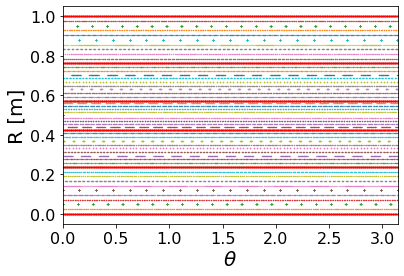

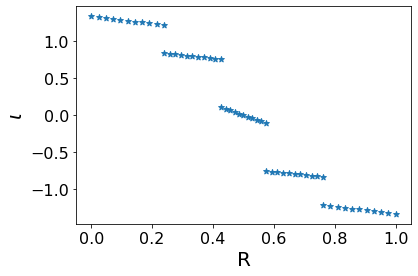

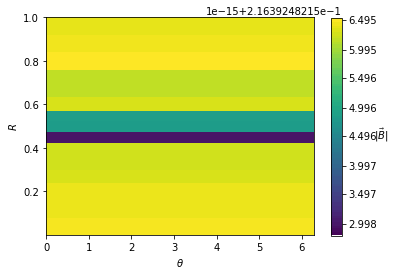

In [17]:
input_file_name='InputFiles/TestCases/G1V05L0Fi.001.sp'
replace_namelist = list()
replace_namelist.append(('diagnosticslist', 'nppts', 1000))
replace_namelist.append(('diagnosticslist', 'nptrj', [10,10,10,10,10]))

result = run_case(input_file_name, ncpus=2, others=replace_namelist, run_master=False)

import matplotlib.pyplot as plt

# poincare plot
fig, ax = plt.subplots()
result.Zernike_output.plot_poincare(ax=ax, s=0.3)
dummy = result.Zernike_output.plot_kam_surface(ax=ax, s=0.6)

# iota plot
fig, ax = plt.subplots()
result.Zernike_output.plot_iota(ax=ax)

# mod B plot
fig, ax = plt.subplots()
result.Zernike_output.plot_modB(ax=ax)

# compare mod B of python tools to the grid data
maxdiff = 0.0
gridmodB = np.sqrt(np.array(result.Zernike_output.grid.BZ)**2 + np.array(result.Zernike_output.grid.Bp)**2)
for i in range(5):
    Lrad = result.Zernike_output.input.physics.Lrad[i]
    Nt = result.Zernike_output.grid.Nt
    Nz = result.Zernike_output.grid.Nz
    Nfp = result.Zernike_output.input.physics.Nfp
    sarr = np.linspace(-1.0,1.0,Lrad+1)
    Bcontra = result.Zernike_output.get_B(lvol=i,sarr=sarr)
    R, Z, jacobian, g = result.Zernike_output.get_grid_and_jacobian_and_metric(lvol=i,sarr=sarr)
    modB = result.Zernike_output.get_modB(Bcontra,g)
    modBg = np.reshape(gridmodB[i,:].T,[Lrad+1,Nt,Nz])
    
    maxdiff = np.max([maxdiff, np.max(np.abs(modB-modBg))])

print('maximum modB difference between grid data and py_spec', maxdiff)

### 4.2 Cylindrical case

Initial guess of the interface geometry ignored: line  102
Initial guess of the interface geometry ignored: line  102
SPEC is running...
SPEC runs successfully.
maximum modB difference between grid data and py_spec 5.551115123125783e-16


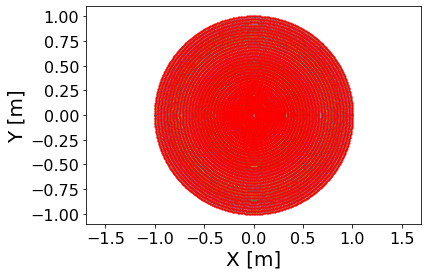

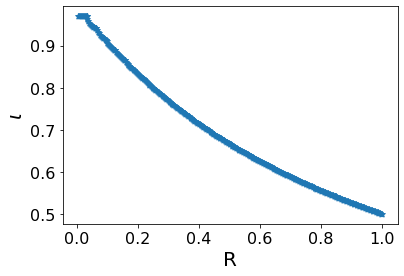

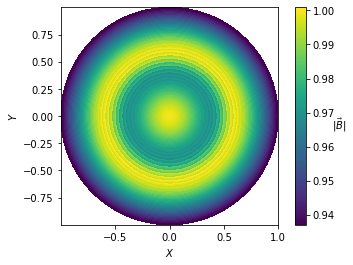

In [18]:
input_file_name='ci/G2V32L1Fi/G2V32L1Fi.001.sp'

replace_namelist = list()
replace_namelist.append(('diagnosticslist', 'nppts', 1000))

result = run_case(input_file_name, ncpus=4, others=replace_namelist, run_master=False)

# check the Poincare plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
result.Zernike_output.plot_poincare(ax=ax, s=0.3)
dummy = result.Zernike_output.plot_kam_surface(ax=ax, s=0.6)

# iota
fig, ax = plt.subplots()
result.Zernike_output.plot_iota(ax=ax)

# modB
fig, ax = plt.subplots()
sarr = np.linspace(-0.99,1.0,4)
tarr = np.linspace(0,2*np.pi,100)
result.Zernike_output.plot_modB(sarr=sarr,tarr=tarr,ax=ax)

# compare mod B of python tools to the grid data
maxdiff = 0.0

for i in range(32):
    gridmodB = np.sqrt(np.array(result.Zernike_output.grid.Bp[i])**2 
                       + np.array(result.Zernike_output.grid.BZ[i]*result.Zernike_output.grid.Rij[i])**2)
    Lrad = result.Zernike_output.input.physics.Lrad[i]
    Nt = result.Zernike_output.grid.Nt
    Nz = result.Zernike_output.grid.Nz
    Nfp = result.Zernike_output.input.physics.Nfp
    sarr = np.linspace(-1.0,1.0,Lrad+1)
    if i==0:
        sarr[0]=-0.999
    Bcontra = result.Zernike_output.get_B(lvol=i,sarr=sarr)
    R, Z, jacobian, g = result.Zernike_output.get_grid_and_jacobian_and_metric(lvol=i,sarr=sarr)
    modB = result.Zernike_output.get_modB(Bcontra,g)
    if i==0: # illegal data on axis for first volume
        modB[0,:,:] = 0.0
    modBg = np.reshape(gridmodB.T,[Lrad+1,Nt,Nz])
    
    localdiff = np.max(np.abs(modB-modBg))
    maxdiff = np.max([maxdiff, localdiff])

print('maximum modB difference between grid data and py_spec', maxdiff)

### 4.3 Toroidal case

SPEC is running...
SPEC runs successfully.
maximum modB difference between grid data and py_spec 2.220446049250313e-15


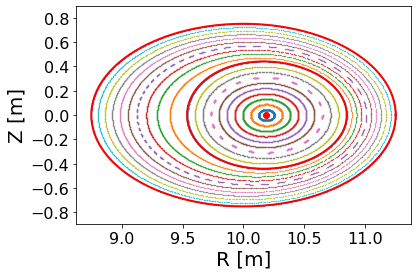

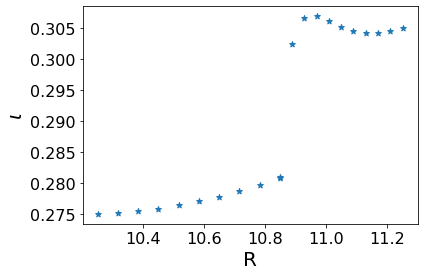

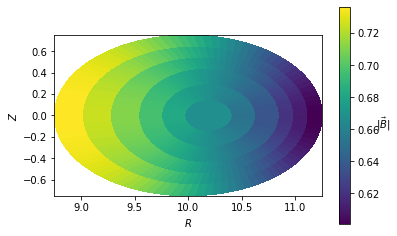

In [19]:
input_file_name='InputFiles/TestCases/G3V02L1Fi.001.sp'

replace_namelist = list()
replace_namelist.append(('diagnosticslist', 'nppts', 1000))
replace_namelist.append(('diagnosticslist', 'nptrj', [10,10]))

result = run_case(input_file_name, ncpus=2, LradZernike=8, others=replace_namelist, run_master=False)

# poincare
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
result.Zernike_output.plot_poincare(ax=ax, s=0.3)
dummy = result.Zernike_output.plot_kam_surface(ax=ax)

# iota
fig, ax = plt.subplots()
result.Zernike_output.plot_iota(ax=ax)

# modB
fig, ax = plt.subplots()
sarr = np.linspace(-0.99,1.0,4)
tarr = np.linspace(0,2*np.pi,100)
result.Zernike_output.plot_modB(sarr=sarr,tarr=tarr,ax=ax)

# compare mod B of python tools to the grid data
maxdiff = 0.0

for i in range(2):
    gridmodB = np.sqrt(np.array(result.Zernike_output.grid.BR[i])**2 + np.array(result.Zernike_output.grid.BZ[i])**2 
                       + np.array(result.Zernike_output.grid.Bp[i]*result.Zernike_output.grid.Rij[i])**2)
    Lrad = result.Zernike_output.input.physics.Lrad[i]
    Nt = result.Zernike_output.grid.Nt
    Nz = result.Zernike_output.grid.Nz
    Nfp = result.Zernike_output.input.physics.Nfp
    sarr = np.linspace(-1.0,1.0,Lrad+1)
    if i==0:
        sarr[0]=-0.999
    tarr = np.linspace(0, 2*np.pi,Nt+1)[:-1]
    zarr = np.linspace(0, 2*np.pi/Nfp,Nz+1)[:-1]
    Bcontra = result.Zernike_output.get_B(lvol=i,sarr=sarr,tarr=tarr,zarr=zarr)
    R, Z, jacobian, g = result.Zernike_output.get_grid_and_jacobian_and_metric(lvol=i,sarr=sarr,tarr=tarr,zarr=zarr)
    modB = result.Zernike_output.get_modB(Bcontra,g)
    if i==0: # illegal data on axis for first volume
        modB[0,:,:] = 0.0
    modBg = np.transpose(np.reshape(gridmodB.T,[Lrad+1,Nz,Nt]),(0,2,1))
    
    localdiff = np.max(np.abs(modB-modBg))
    maxdiff = np.max([maxdiff, localdiff])

print('maximum modB difference between grid data and py_spec', maxdiff)